<a href="https://colab.research.google.com/github/AnnaVashuk/NODE/blob/main/node_full_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from sklearn.preprocessing import MinMaxScaler
import time
from io import StringIO
from sklearn.metrics import mean_squared_error

**Первый эксперимент: синусоида с шумом**

Epoch 0, Loss: 0.5765
Epoch 10, Loss: 0.0635
Epoch 20, Loss: 0.0150
Epoch 30, Loss: 0.0185
Epoch 40, Loss: 0.0127
Общее время обучения: 21.38 секунд
Test MSE: 0.0115


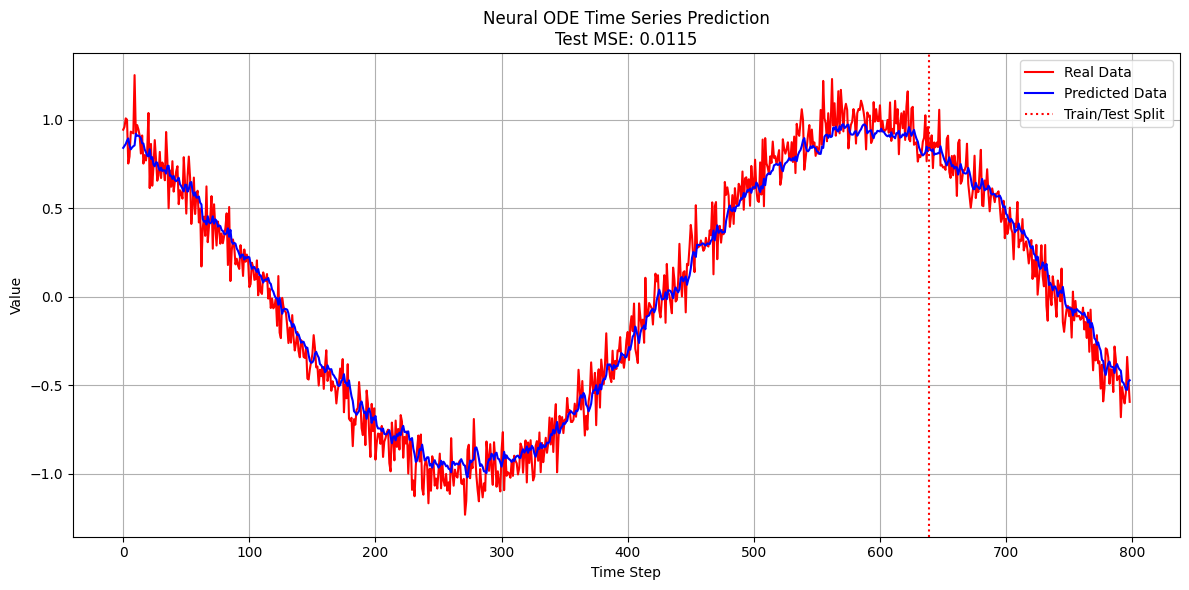

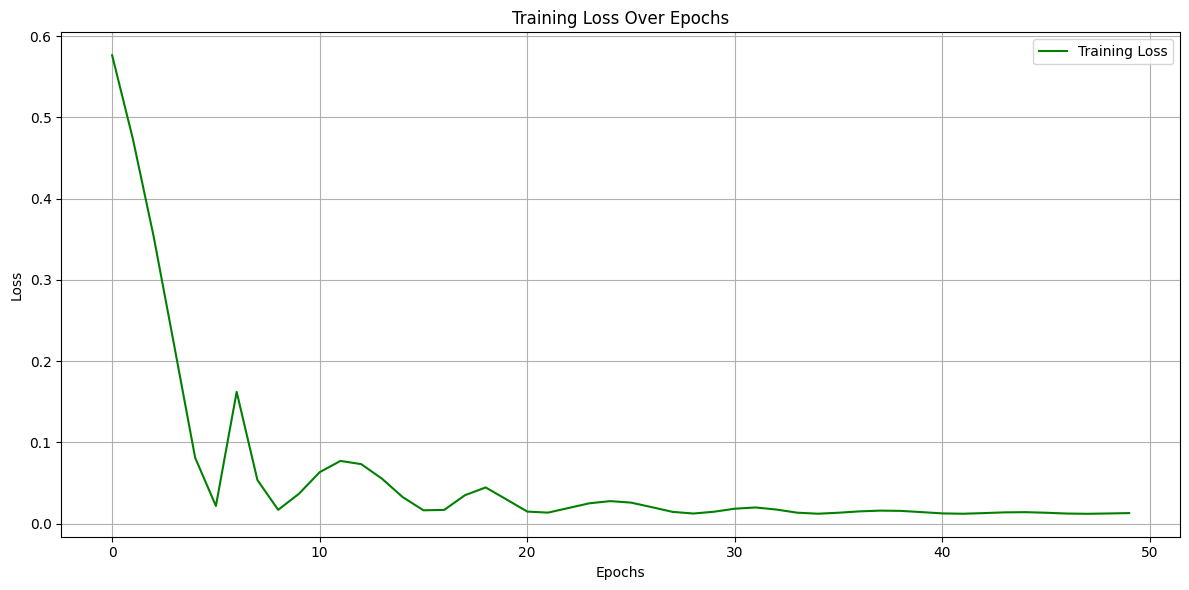

In [ ]:
# фиксация случайности
np.random.seed(42)
torch.manual_seed(42)

# генерация данных: синусоида + шум
t = np.linspace(0, 10, 1000)
data = np.sin(t) + 0.1 * np.random.randn(len(t))
data = torch.tensor(data, dtype=torch.float32)

# замена NaN и нулей
data = torch.nan_to_num(data, nan=0.01)
data = torch.where(data == 0, torch.tensor(0.01), data)

# формирование обучающей выборки
seq_length = 200
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

X = torch.stack(X).unsqueeze(-1)
Y = torch.stack(Y)[:, None]

# разделение на train/test
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# ODE-функция
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

# модель с RNN и Neural ODE
class ODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(ODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        t = torch.linspace(0, 1, steps=10)
        ode_out = odeint(self.odefunc, hidden.squeeze(0), t)
        output = self.fc(ode_out[-1])
        return output

# инициализация модели
input_dim = 1
hidden_size = 16
model = ODEModel(input_dim, hidden_size)

# обучение
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
start_time = time.time()

train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавляем значение потерь в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# оценка модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# объединение предсказаний и истинных значений
all_true = torch.cat([Y_train, Y_test]).numpy()
all_preds = torch.cat([train_preds, test_preds]).numpy()

# вычисление ошибки на тесте
test_mse = mean_squared_error(Y_test.numpy(), test_preds.numpy())
print(f"Test MSE: {test_mse:.4f}")

# визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_preds, label="Predicted Data", color='blue')
plt.axvline(x=len(Y_train), color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Neural ODE Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.5689
Epoch 10, Loss: 0.0386
Epoch 20, Loss: 0.0251
Epoch 30, Loss: 0.0136
Epoch 40, Loss: 0.0141
Общее время обучения: 20.43 секунд
Test MSE: 0.0122


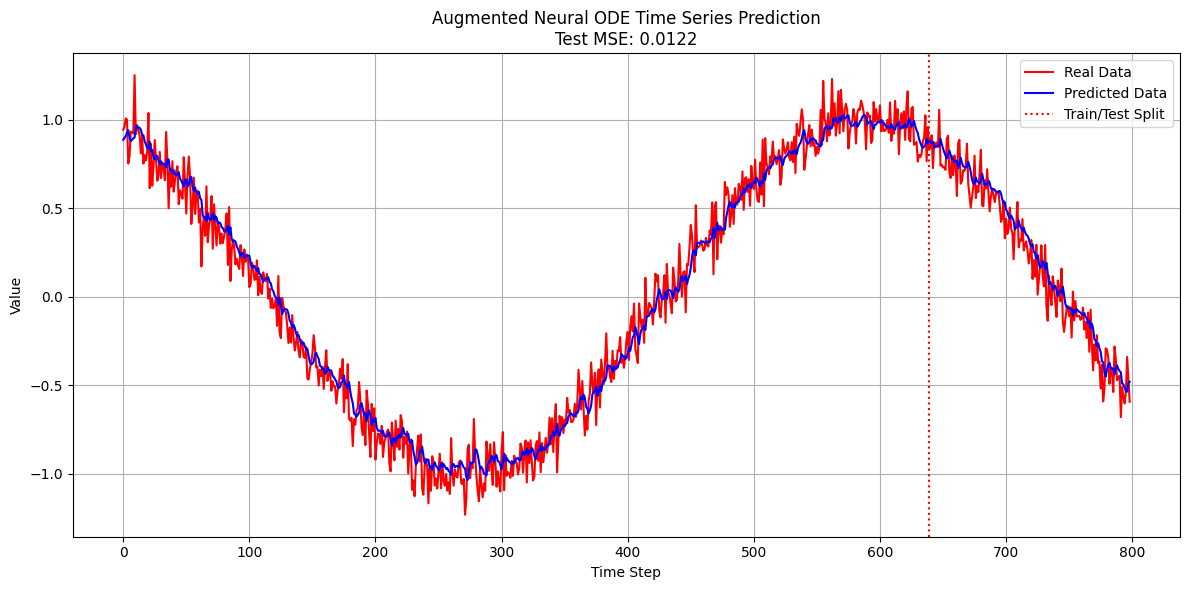

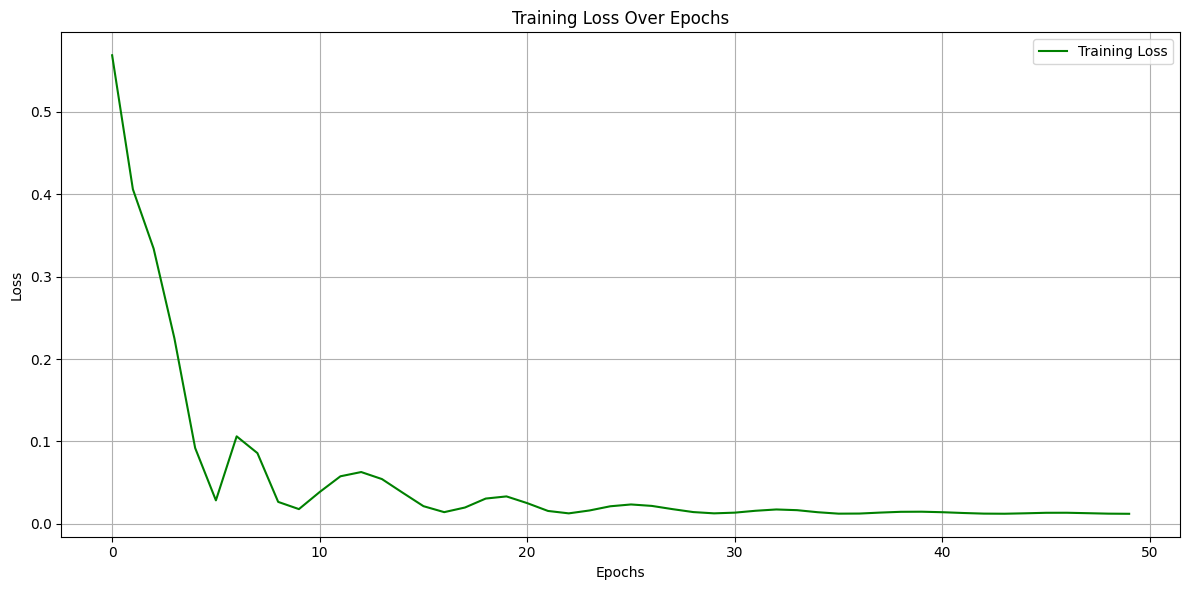

In [ ]:
# Augmented Neural ODE
class AugmentedODEFunc(nn.Module):
    def __init__(self, hidden_size, aug_dim=2):
        super(AugmentedODEFunc, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim  # добавляем дополнительные измерения
        self.net = nn.Sequential(
            nn.Linear(hidden_size + aug_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size + aug_dim)
        )

    def forward(self, t, x):
        return self.net(x)

# Augmented Neural ODE модель
class AugmentedODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size, aug_dim=2):
        super(AugmentedODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = AugmentedODEFunc(hidden_size, aug_dim)
        self.fc = nn.Linear(hidden_size + aug_dim, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        hidden = hidden.squeeze(0)

        aug_hidden = torch.cat([hidden, torch.zeros(hidden.shape[0], self.aug_dim)], dim=1)  # добавляем дополнительные измерения

        t = torch.linspace(0, 1, steps=10)
        ode_out = odeint(self.odefunc, aug_hidden, t)  # решаем ODE в увеличенном пространстве

        output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
aug_dim = 2  # добавляем 2 дополнительных измерения
model = AugmentedODEModel(input_dim, hidden_size, aug_dim)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# список для потерь
train_losses = []

# обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавление потерь в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# объединяем реальные и предсказанные значения
all_true = torch.cat([Y_train, Y_test]).numpy()
all_preds = torch.cat([train_preds, test_preds]).numpy()

# индекс раздела train/test
split_idx = len(Y_train)

# вычисляем MSE для теста
test_mse = mean_squared_error(Y_test.numpy(), test_preds.numpy())
print(f"Test MSE: {test_mse:.4f}")

# визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_preds, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Augmented Neural ODE Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация функции потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.5176
Epoch 10, Loss: 0.0619
Epoch 20, Loss: 0.0191
Epoch 30, Loss: 0.0237
Epoch 40, Loss: 0.0186
Общее время обучения: 22.93 секунд
Test MSE: 0.0186


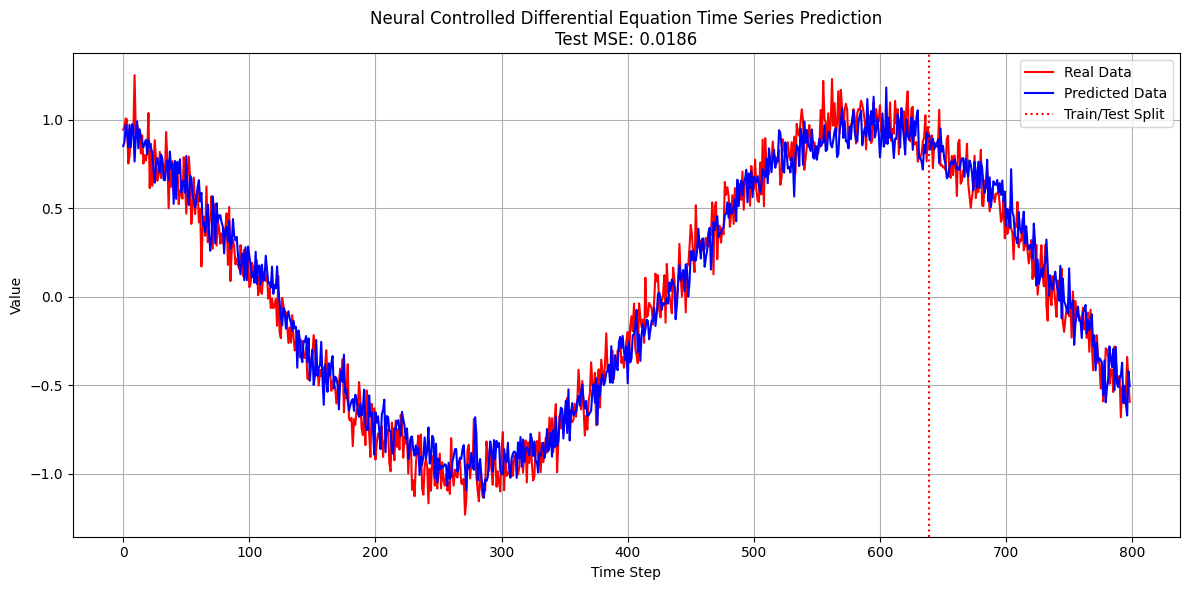

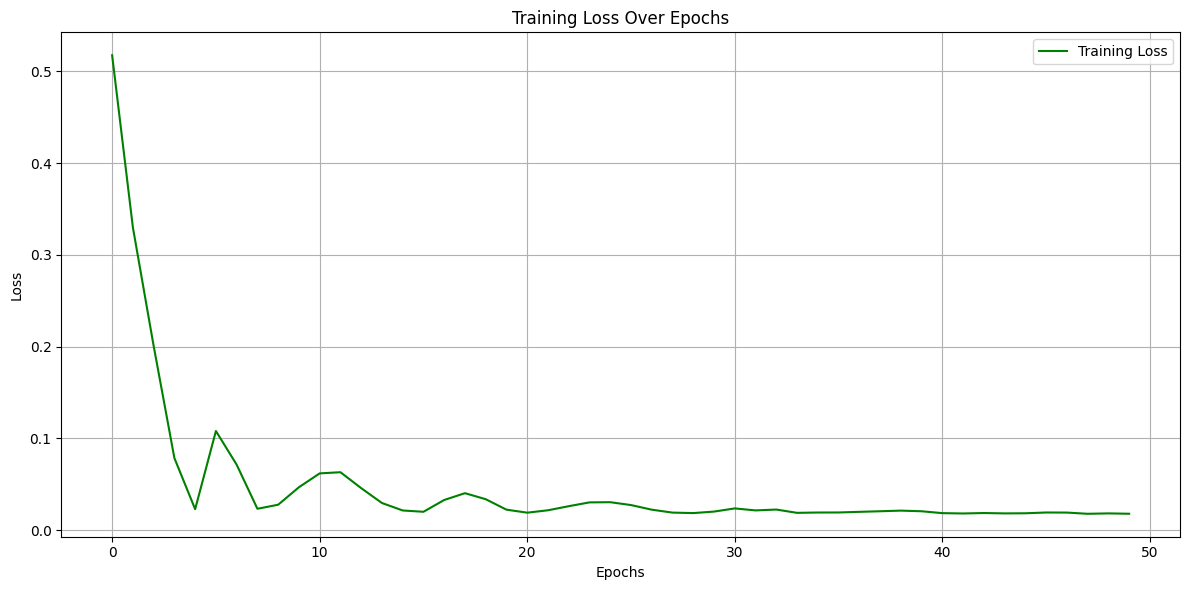

In [ ]:
# Neural Controlled Differential Equation (NCDE)
class NCDEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(NCDEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x, control):
        # управление добавляется к динамике
        return self.net(x) + control  # контроль влияет на изменение состояния

# NCDE модель
class NCDEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NCDEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.ncdefunc = NCDEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        t = torch.linspace(0, 1, steps=10)
        control = torch.randn_like(hidden) * 0.1  # случайный контроль, который влияет на динамику
        ode_out = odeint(lambda t, x: self.ncdefunc(t, x, control), hidden.squeeze(0), t)
        output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
model = NCDEModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# список для потерь
train_losses = []

# обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавление потерь в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# объединяем реальные и предсказанные значения
all_true = torch.cat([Y_train, Y_test]).numpy()
all_preds = torch.cat([train_preds, test_preds]).numpy()

# индекс раздела train/test
split_idx = len(Y_train)

# вычисляем MSE для теста
test_mse = mean_squared_error(Y_test.numpy(), test_preds.numpy())
print(f"Test MSE: {test_mse:.4f}")

# визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_preds, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Neural Controlled Differential Equation Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация функции потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.7315
Epoch 10, Loss: 0.0405
Epoch 20, Loss: 0.0222
Epoch 30, Loss: 0.0139
Epoch 40, Loss: 0.0140
Общее время обучения: 20.53 секунд
Test MSE: 0.0113


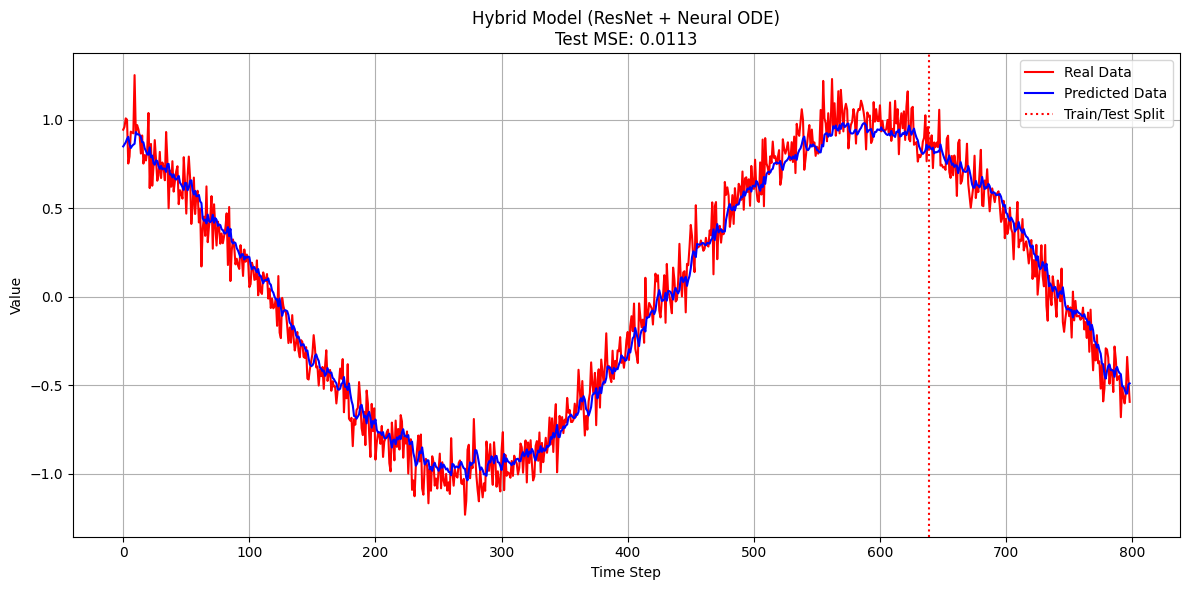

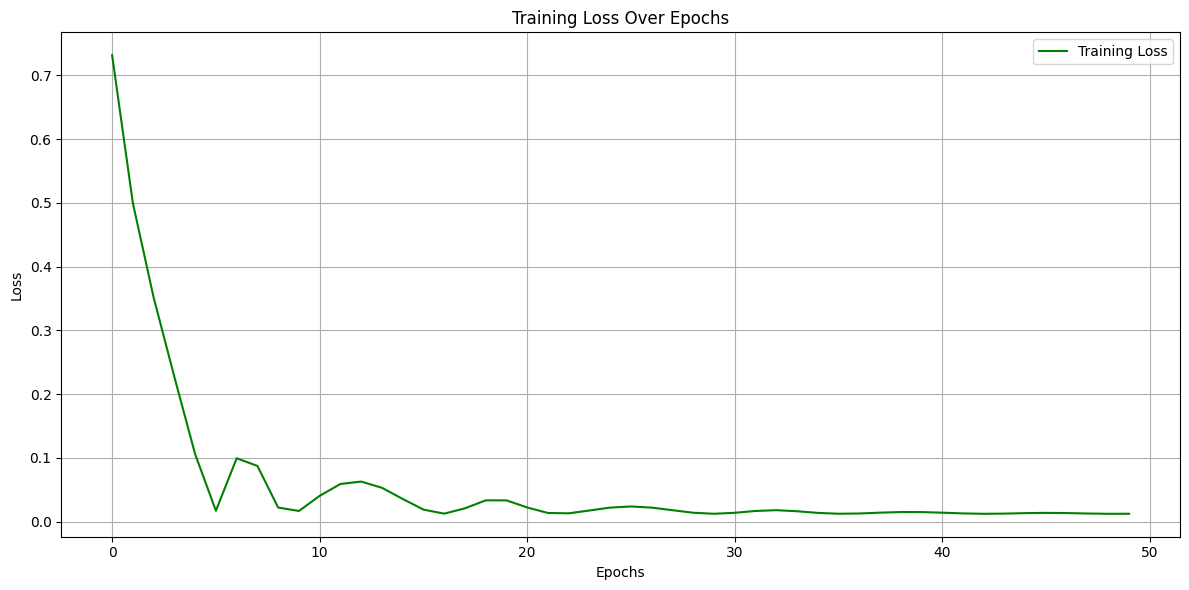

In [ ]:
# ResNet блок
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        return x + self.net(x)

# Neural ODE. Определяем функцию динамики
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

# модель, которая использует либо ResNet, либо ODE в зависимости от вероятности p = 1/t
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HybridModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.resnet = ResNetBlock(hidden_size)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #(batch, seq_len, hidden_size)
        hidden = hidden.squeeze(0)  # получаем скрытое состояние RNN

        t = torch.linspace(0, 1, steps=10).to(x.device)
        p = 1.0 / t  # вероятность выбора ODE

        # случайный выбор между ODE и ResNet
        if torch.rand(1).item() < p[-1].item():
            ode_out = odeint(self.odefunc, hidden, t)  # пешаем ODE
            output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        else:
            output = self.fc(self.resnet(hidden))  # прогнозируем через ResNet

        return output

input_dim = 1
hidden_size = 16
model = HybridModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

train_losses = []

# обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавление потерь в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# объединяем реальные и предсказанные значения
all_true = torch.cat([Y_train, Y_test]).numpy()
all_preds = torch.cat([train_preds, test_preds]).numpy()

# индекс раздела train/test
split_idx = len(Y_train)

# вычисляем MSE для теста
test_mse = mean_squared_error(Y_test.numpy(), test_preds.numpy())
print(f"Test MSE: {test_mse:.4f}")

# визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_preds, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Hybrid Model (ResNet + Neural ODE)\nTest MSE: {test_mse:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация функции потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.5514
Epoch 10, Loss: 0.0262
Epoch 20, Loss: 0.0306
Epoch 30, Loss: 0.0139
Epoch 40, Loss: 0.0137
Общее время обучения: 15.35 секунд
Test MSE: 0.0134


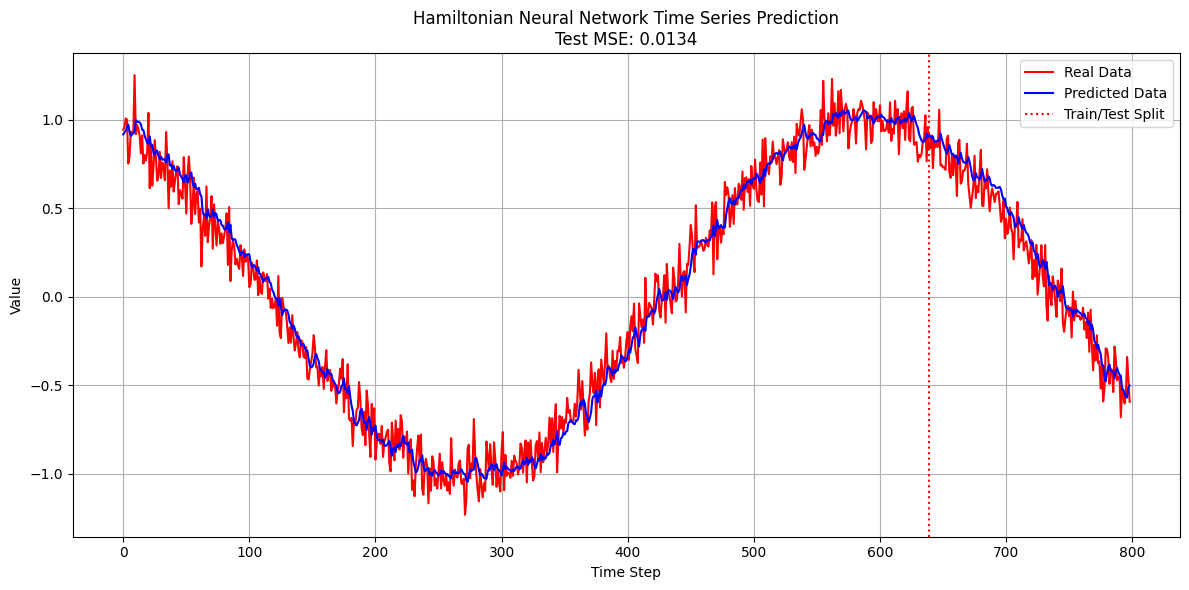

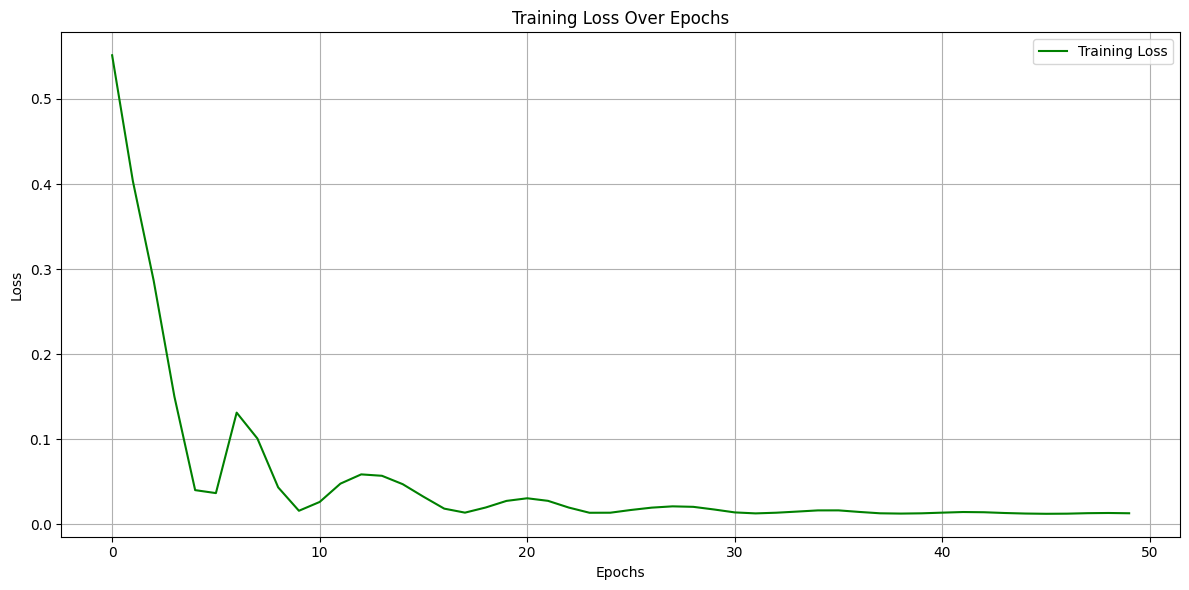

In [ ]:
# Hamiltonian Neural Network
class HamiltonianNN(nn.Module):
    def __init__(self, hidden_size):
        super(HamiltonianNN, self).__init__()
        self.kinetic = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )
        self.potential = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T, V

# ODE модель с гамильтоновым механизмом
class HNNModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.hnn = HamiltonianNN(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # прямой проход
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        hidden = hidden.squeeze(0)  # убираем размерность batch

        T, V = self.hnn(hidden)  # используем HNN для получения кинетической и потенциальной энергии

        hamiltonian_dynamics = T - V  # итоговая динамика HNN без явного дифференцирования

        output = self.fc(hamiltonian_dynamics)  # прогнозируем
        return output

input_dim = 1
hidden_size = 16
model = HNNModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# список для потерь
train_losses = []

# обучение модели
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавление потерь в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# объединяем реальные и предсказанные значения
all_true = torch.cat([Y_train, Y_test]).numpy()
all_preds = torch.cat([train_preds, test_preds]).numpy()

# индекс раздела train/test
split_idx = len(Y_train)

# вычисляем MSE для теста
test_mse = mean_squared_error(Y_test.numpy(), test_preds.numpy())
print(f"Test MSE: {test_mse:.4f}")

# визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_preds, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label='Train/Test Split')
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title(f"Hamiltonian Neural Network Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация функции потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('d.csv')
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
scaler = MinMaxScaler()
df['humidity'] = scaler.fit_transform(df[['humidity']]) #приведем значения к диапазону [0, 1]

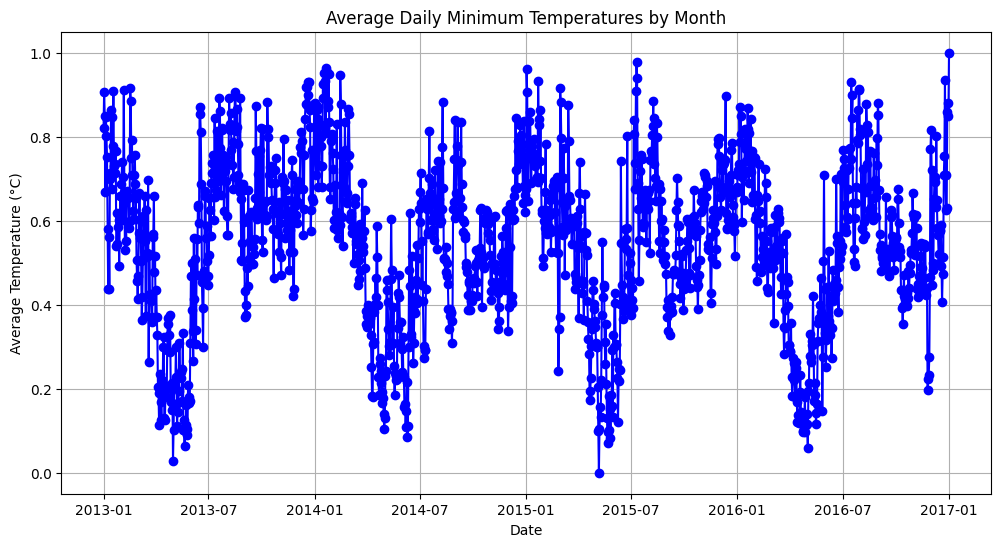

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)
df['humidity'] = pd.to_numeric(df['humidity'], errors='coerce')

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['humidity'], marker='o', linestyle='-', color='blue')
plt.title('Average Daily Minimum Temperatures by Month')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.grid(True)
plt.show()

In [ ]:
df = df.drop(['meantemp', 'wind_speed', 'meanpressure'], axis=1)
df

,humidity
date,
2013-01-01,0.820957
2013-01-02,0.907591
2013-01-03,0.849835
2013-01-04,0.668867
2013-01-05,0.847910
...,...
2016-12-28,0.630865
2016-12-29,0.859736
2016-12-30,0.880638


Epoch 0, Loss: 0.3347
Epoch 10, Loss: 0.0256
Epoch 20, Loss: 0.0263
Epoch 30, Loss: 0.0150
Epoch 40, Loss: 0.0096
Общее время обучения: 36.25 секунд
Test MSE: 0.0091


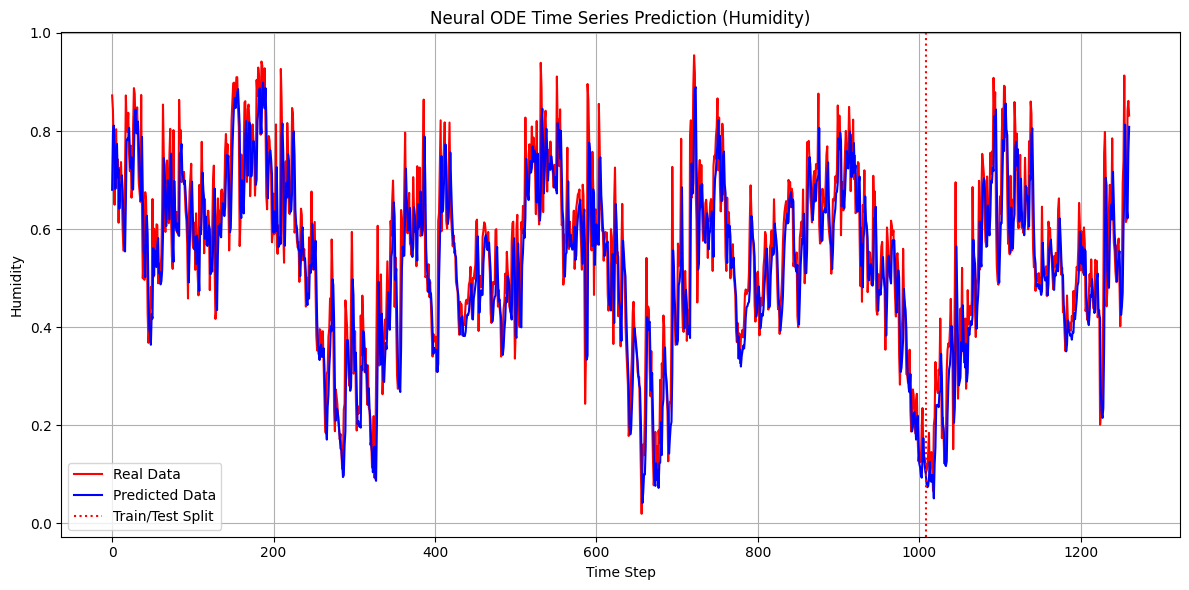

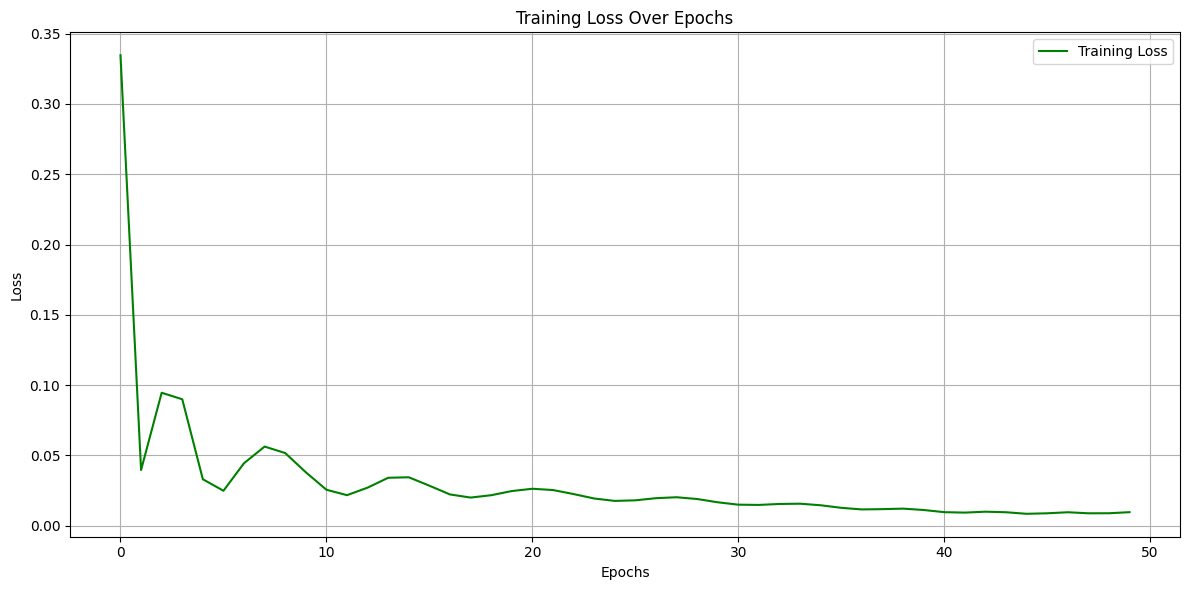

In [ ]:
data = torch.tensor(df['humidity'].values, dtype=torch.float32)
data = torch.nan_to_num(data, nan=0.01)
data = torch.where(data == 0, torch.tensor(0.01), data)

# создание обучающих последовательностей
seq_length = 200  # количество точек во входной последовательности
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

X = torch.stack(X).unsqueeze(-1)  # input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # разделение на train и test выборку

# Neural ODE — функция динамики
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

# Neural ODE модель
class ODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(ODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        t = torch.linspace(0, 1, steps=10).to(x.device)  # временная сетка для ODE
        ode_out = odeint(self.odefunc, hidden.squeeze(0), t)
        output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        return output

# параметры модели
input_dim = 1
hidden_size = 16
model = ODEModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# обучение модели
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавляем потери в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# инверсия нормализации
scaler = MinMaxScaler()
scaler.fit(Y_train.numpy())

Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())
train_preds_inv = scaler.inverse_transform(train_preds.numpy())
Y_train_inv = scaler.inverse_transform(Y_train.numpy())

# Объединяем данные для графика
all_true = np.concatenate([Y_train_inv, Y_test_inv])
all_pred = np.concatenate([train_preds_inv, test_preds_inv])
split_idx = len(Y_train)

# Оценка модели
test_mse = mean_squared_error(Y_test_inv, test_preds_inv)
print(f"Test MSE: {test_mse:.4f}")

# визуализация: Реальные и предсказанные данные
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_pred, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label="Train/Test Split")
plt.title(f"Neural ODE Time Series Prediction (Humidity)")
plt.xlabel("Time Step")
plt.ylabel("Humidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.4342
Epoch 10, Loss: 0.0566
Epoch 20, Loss: 0.0302
Epoch 30, Loss: 0.0277
Epoch 40, Loss: 0.0169
Общее время обучения: 25.76 секунд
Test MSE: 0.0128


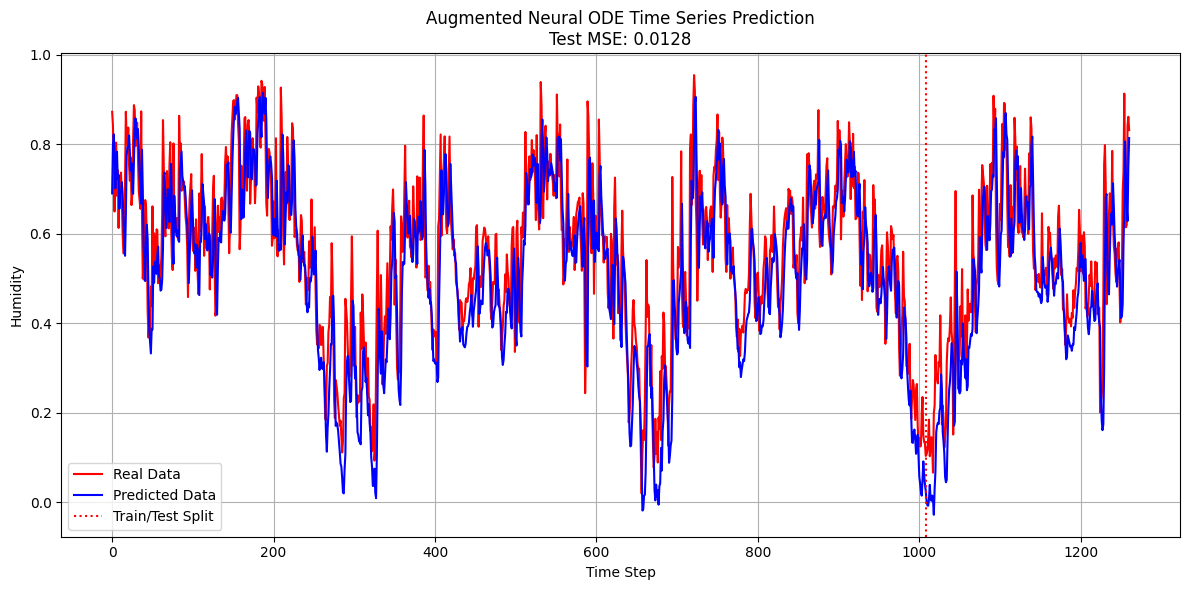

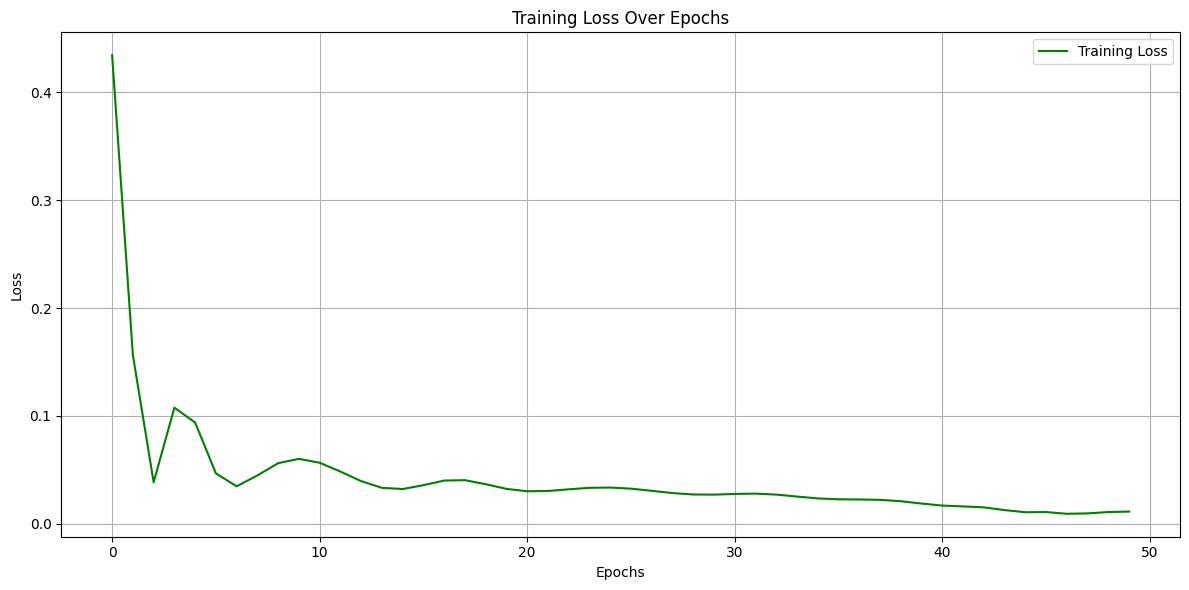

In [ ]:
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

X = torch.stack(X).unsqueeze(-1)  # input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Augmented Neural ODE. Определяем функцию динамики
class AugmentedODEFunc(nn.Module):
    def __init__(self, hidden_size, aug_dim=2):
        super(AugmentedODEFunc, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim  # добавляем дополнительные измерения
        self.net = nn.Sequential(
            nn.Linear(hidden_size + aug_dim, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size + aug_dim)
        )

    def forward(self, t, x):
        return self.net(x)

# Augmented Neural ODE модель
class AugmentedODEModel(nn.Module):
    def __init__(self, input_dim, hidden_size, aug_dim=2):
        super(AugmentedODEModel, self).__init__()
        self.hidden_size = hidden_size
        self.aug_dim = aug_dim
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.odefunc = AugmentedODEFunc(hidden_size, aug_dim)
        self.fc = nn.Linear(hidden_size + aug_dim, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        hidden = hidden.squeeze(0)

        aug_hidden = torch.cat([hidden, torch.zeros(hidden.shape[0], self.aug_dim)], dim=1)  # добавляем дополнительные измерения

        t = torch.linspace(0, 1, steps=10)
        ode_out = odeint(self.odefunc, aug_hidden, t)  # решаем ODE в увеличенном пространстве

        output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        return output

input_dim = 1
hidden_size = 16
aug_dim = 2  # добавляем 2 дополнительных измерения
model = AugmentedODEModel(input_dim, hidden_size, aug_dim)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# обучение модели
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавляем потери в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# инверсия нормализации
scaler = MinMaxScaler()
scaler.fit(Y_train.numpy())

Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())
train_preds_inv = scaler.inverse_transform(train_preds.numpy())
Y_train_inv = scaler.inverse_transform(Y_train.numpy())

all_true = np.concatenate([Y_train_inv, Y_test_inv])
all_pred = np.concatenate([train_preds_inv, test_preds_inv])
split_idx = len(Y_train)

test_mse = mean_squared_error(Y_test_inv, test_preds_inv)
print(f"Test MSE: {test_mse:.4f}")

# визуализация: Реальные и предсказанные данные
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_pred, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label="Train/Test Split")
plt.title(f"Augmented Neural ODE Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.xlabel("Time Step")
plt.ylabel("Humidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.0329
Epoch 10, Loss: 0.0254
Epoch 20, Loss: 0.0222
Epoch 30, Loss: 0.0118
Epoch 40, Loss: 0.0114
Общее время обучения: 34.82 секунд
Test MSE: 0.0107


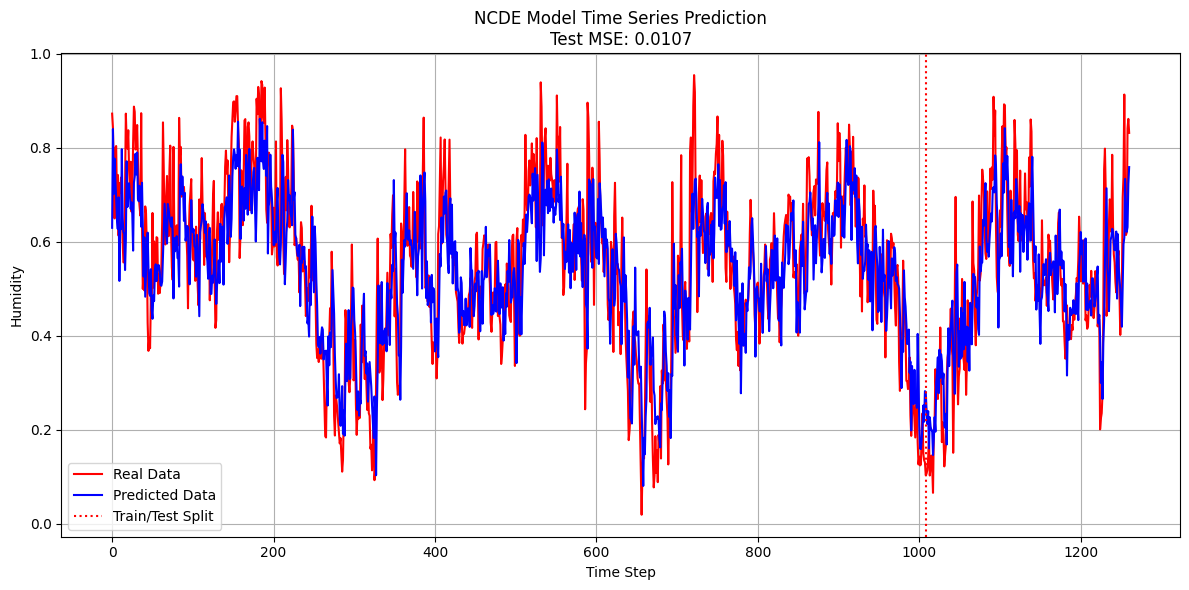

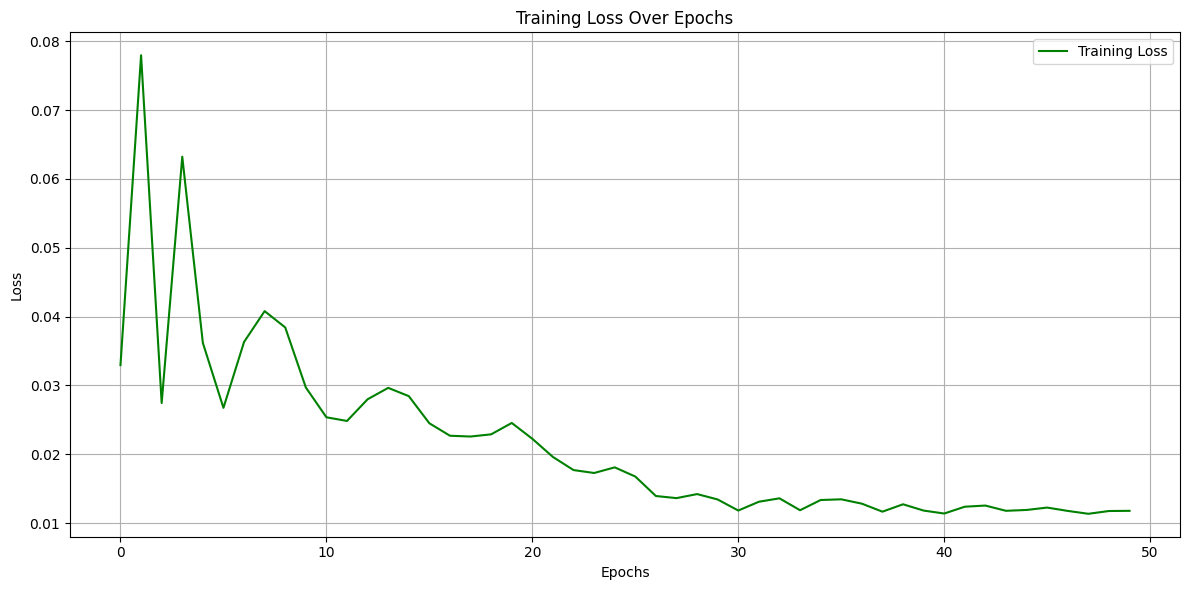

In [ ]:
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

# преобразуем X в (batch, seq_length, input_dim)
X = torch.stack(X).unsqueeze(-1)  # input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # разделение на train и test выборку

# Neural Controlled Differential Equation (NCDE). Определяем функцию динамики с контролем
class NCDEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(NCDEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x, control):
        # управление добавляется к динамике
        return self.net(x) + control  # контроль влияет на изменение состояния

# NCDE модель
class NCDEModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(NCDEModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.ncdefunc = NCDEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # получаем скрытое состояние RNN
        t = torch.linspace(0, 1, steps=10).to(x.device)  # временная сетка для ODE
        control = torch.randn_like(hidden) * 0.1  # случайный контроль, который влияет на динамику
        ode_out = odeint(lambda t, x: self.ncdefunc(t, x, control), hidden.squeeze(0), t)
        output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        return output

# инициализация модели
input_dim = 1
hidden_size = 16
model = NCDEModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# обучение модели
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    # добавляем потери в список
    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# инверсия нормализации
scaler = MinMaxScaler()
scaler.fit(Y_train.numpy())

Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())
train_preds_inv = scaler.inverse_transform(train_preds.numpy())
Y_train_inv = scaler.inverse_transform(Y_train.numpy())

all_true = np.concatenate([Y_train_inv, Y_test_inv])
all_pred = np.concatenate([train_preds_inv, test_preds_inv])
split_idx = len(Y_train)

test_mse = mean_squared_error(Y_test_inv, test_preds_inv)
print(f"Test MSE: {test_mse:.4f}")

# визуализация: Реальные и предсказанные данные
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_pred, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label="Train/Test Split")
plt.title(f"NCDE Model Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.xlabel("Time Step")
plt.ylabel("Humidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 0, Loss: 0.2625
Epoch 10, Loss: 0.0367
Epoch 20, Loss: 0.0196
Epoch 30, Loss: 0.0161
Epoch 40, Loss: 0.0100
Общее время обучения: 50.32 секунд
Test MSE: 0.0088


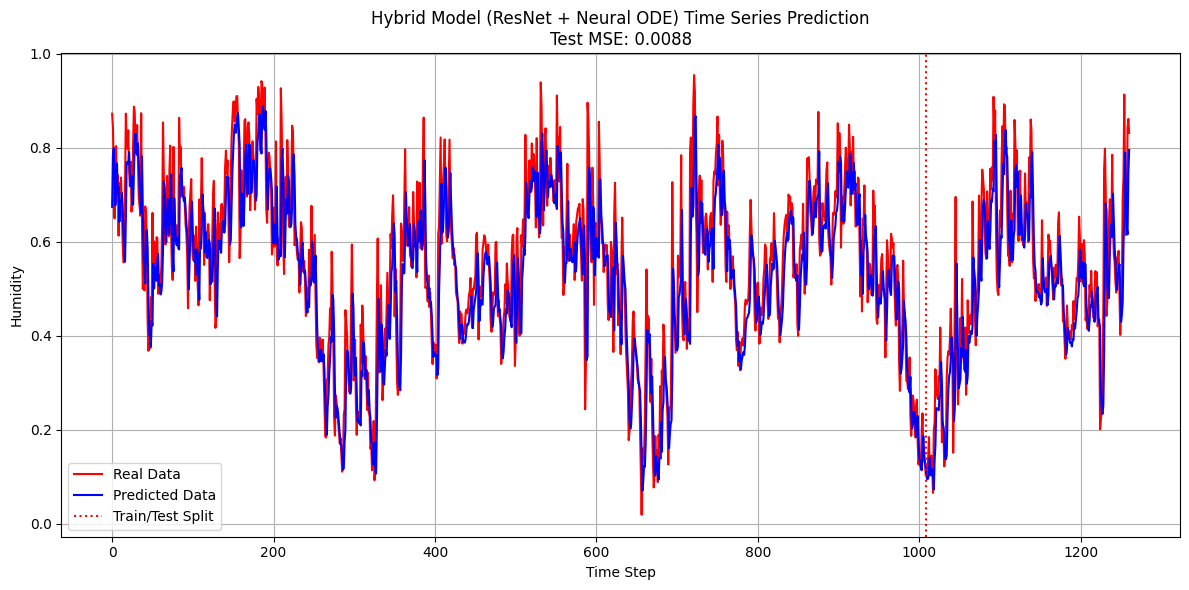

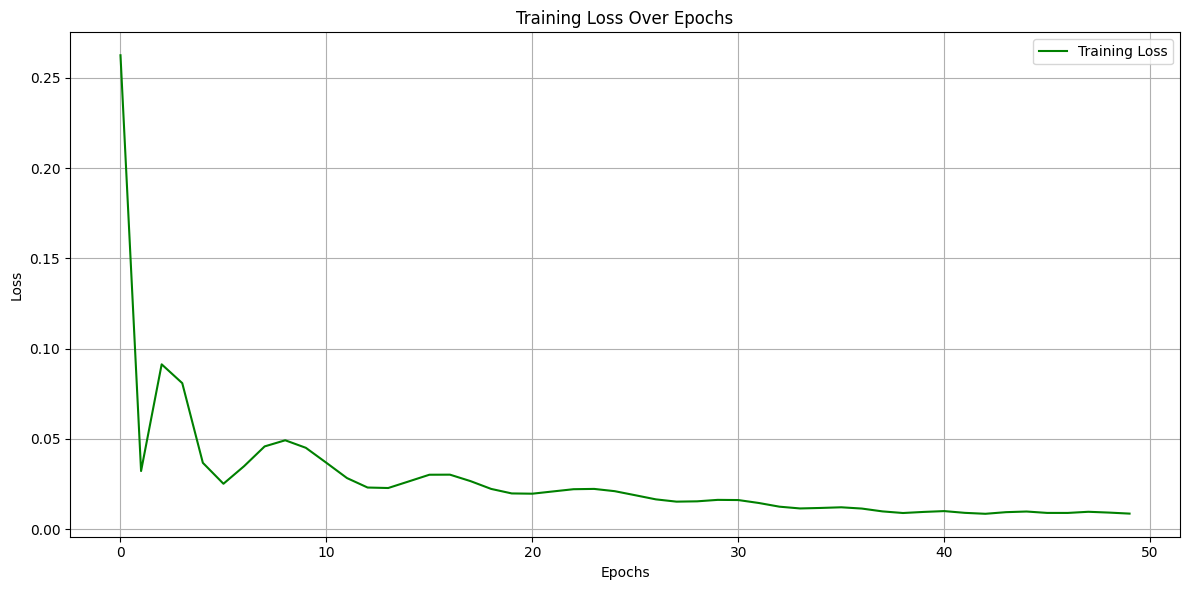

In [ ]:
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

# преобразуем X в (batch, seq_length, input_dim)
X = torch.stack(X).unsqueeze(-1)  # input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # разделение на train и test выборку

# ResNet блок
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        return x + self.net(x)

# Neural ODE. Определяем функцию динамики
class ODEFunc(nn.Module):
    def __init__(self, hidden_size):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.Tanh(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, t, x):
        return self.net(x)

# модель, которая использует либо ResNet, либо ODE в зависимости от вероятности p = 1/t
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HybridModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.resnet = ResNetBlock(hidden_size)
        self.odefunc = ODEFunc(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  #(batch, seq_len, hidden_size)
        hidden = hidden.squeeze(0)  # получаем скрытое состояние RNN

        t = torch.linspace(0, 1, steps=10).to(x.device)
        p = 1.0 / t # считаем вероятность p = 1/t для выбора между ResNet и ODE

        # условие вероятности
        if torch.rand(1).item() < p[-1].item():
            ode_out = odeint(self.odefunc, hidden, t)  # решаем ODE
            output = self.fc(ode_out[-1])  # прогнозируем будущее значение
        else:
            output = self.fc(self.resnet(hidden))  # прогнозируем через ResNet

        return output

# инициализация модели
input_dim = 1
hidden_size = 16
model = HybridModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# счетчик времени
start_time = time.time()

# обучение модели
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# тестирование модели
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# инверсия нормализации
scaler = MinMaxScaler()
scaler.fit(Y_train.numpy())

Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())
train_preds_inv = scaler.inverse_transform(train_preds.numpy())
Y_train_inv = scaler.inverse_transform(Y_train.numpy())

all_true = np.concatenate([Y_train_inv, Y_test_inv])
all_pred = np.concatenate([train_preds_inv, test_preds_inv])
split_idx = len(Y_train)

test_mse = mean_squared_error(Y_test_inv, test_preds_inv)
print(f"Test MSE: {test_mse:.4f}")

# визуализация: Реальные и предсказанные данные
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_pred, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label="Train/Test Split")
plt.title(f"Hybrid Model (ResNet + Neural ODE) Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.xlabel("Time Step")
plt.ylabel("Humidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 0, Loss: 0.2270
Epoch 10, Loss: 0.0364
Epoch 20, Loss: 0.0253
Epoch 30, Loss: 0.0122
Epoch 40, Loss: 0.0095
Общее время обучения: 30.95 секунд
Test MSE: 0.0084


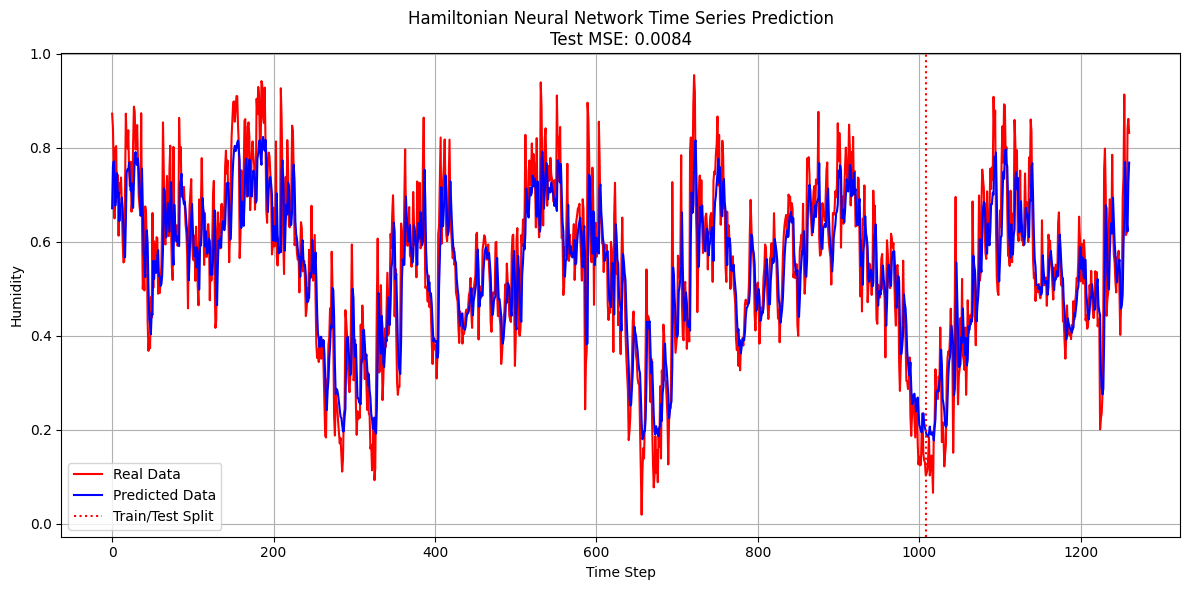

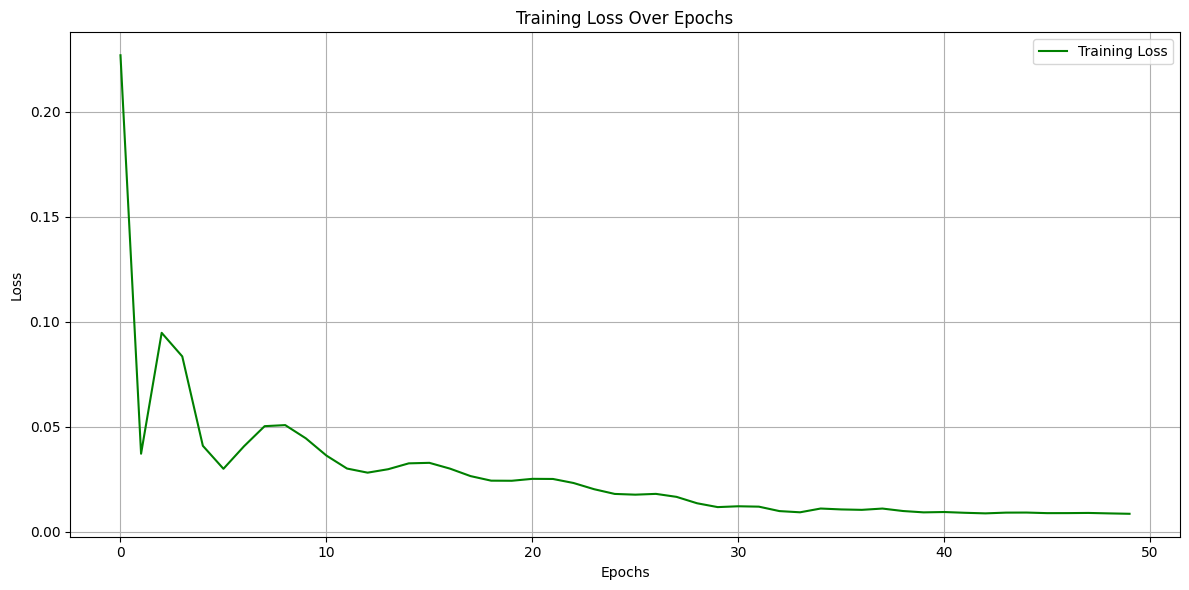

In [ ]:
X, Y = [], []

for i in range(len(data) - seq_length - 1):
    X.append(data[i : i + seq_length])
    Y.append(data[i + seq_length])

# преобразуем X в (batch, seq_length, input_dim)
X = torch.stack(X).unsqueeze(-1)  # input_dim = 1
Y = torch.stack(Y)[:, None]

train_size = int(len(X)*0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]  # разделение на train и test выборку

# Hamiltonian Neural Network блок
class HamiltonianNN(nn.Module):
    def __init__(self, hidden_size):
        super(HamiltonianNN, self).__init__()
        self.kinetic = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )
        self.potential = nn.Sequential(
            nn.Linear(hidden_size, 50),
            nn.ReLU(),
            nn.Linear(50, hidden_size)
        )

    def forward(self, x):
        T = self.kinetic(x)
        V = self.potential(x)
        return T, V

# HNN модель
class HNNModel(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(HNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_dim, hidden_size, batch_first=True)
        self.hnn = HamiltonianNN(hidden_size)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)
        hidden = hidden.squeeze(0)

        T, V = self.hnn(hidden)
        hamiltonian_dynamics = T - V

        output = self.fc(hamiltonian_dynamics)
        return output

# инициализация модели
input_dim = 1
hidden_size = 16
model = HNNModel(input_dim, hidden_size)

# оптимизация
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# обучение
start_time = time.time()
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, Y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

end_time = time.time()
training_time = end_time - start_time
print(f"Общее время обучения: {training_time:.2f} секунд")

# предсказания
with torch.no_grad():
    train_preds = model(X_train)
    test_preds = model(X_test)

# инверсия нормализации
scaler = MinMaxScaler()
scaler.fit(Y_train.numpy())

Y_test_inv = scaler.inverse_transform(Y_test.numpy())
test_preds_inv = scaler.inverse_transform(test_preds.numpy())
train_preds_inv = scaler.inverse_transform(train_preds.numpy())
Y_train_inv = scaler.inverse_transform(Y_train.numpy())

all_true = np.concatenate([Y_train_inv, Y_test_inv])
all_pred = np.concatenate([train_preds_inv, test_preds_inv])
split_idx = len(Y_train)

test_mse = mean_squared_error(Y_test_inv, test_preds_inv)
print(f"Test MSE: {test_mse:.4f}")

# визуализация
plt.figure(figsize=(12, 6))
plt.plot(all_true, label="Real Data", color='red')
plt.plot(all_pred, label="Predicted Data", color='blue')
plt.axvline(x=split_idx, color='red', linestyle=':', label="Train/Test Split")
plt.title(f"Hamiltonian Neural Network Time Series Prediction\nTest MSE: {test_mse:.4f}")
plt.xlabel("Time Step")
plt.ylabel("Humidity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', color='green')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
